# Import data methods:
1. Reading zero-crossing file and extract time, frequency, amplitude and metadata information.(preferred)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from util.bat import *
import random
import os
import scipy.stats as stats
import pandas as pd
import seaborn as sns

# Set some Pandas options
pd.set_option('notebook_repr_html', True)
pd.set_option('max_columns', 30)
pd.set_option('max_rows', 20)

In [2]:
# Call extract_anabat from util.anabat to extract time, frequency, amplitude and partial metadata from zero-crossing file
info=extract_anabat('../data/P7132033.37#')  # P7132035.14#  P7132033.37#  ../data/social/S8072135.07#
# info2=extract_anabat('../data/social/S8072135.07#') 

In [3]:
t=info[0]
freq=info[1]
ampl=info[2]
metadata=info[3]

In [4]:
# tf=np.c_[t,freq]
# tf=pd.DataFrame(tf)
# tf.columns=('time','frequency')
# tf
# a=tf[(tf['time']>1.0)&(tf['time']<1.5)]
# a['time'].values

In [5]:
metadata

{'date': '        ',
 'divratio': 8,
 'gps': '',
 'id': '',
 'loc': '',
 'note1': 'V4062g',
 'note2': '',
 'spec': 'SD1 Mod1',
 'species': ['PERSUB '],
 'timestamp': datetime.datetime(2015, 7, 13, 20, 33, 37, 290175)}

In [6]:
t[-1]-t[0]

11.817265999999998

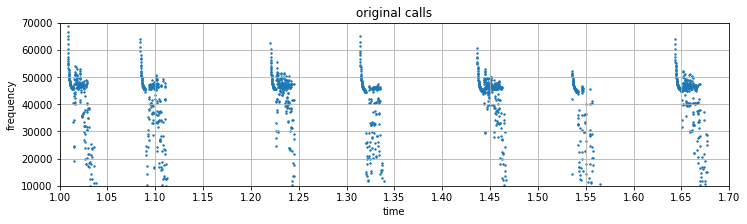

In [27]:
#visualization
plt.figure(figsize=(12,3))
plt.scatter(t, freq, s=2)
plt.xticks(np.arange(1, 1.8, 0.05))
plt.xlim(1, 1.7)
plt.ylim(10000, 70000)
plt.title("original calls")
plt.xlabel("time")
plt.ylabel("frequency")
plt.grid()

2.Read from .csv files of time and freq that decoded using R.

In [8]:
# Read time and frequency data from a csv sample data file. 
# The data in csv file is processed using R from Bat acoustic recording (zero-crossing file) encoded by Anabat file format 132.(AnabatTools.R--see R codes for details)
import csv

call_list = list(csv.reader(open('../data/P7132033_37.csv', 'rb')))[1:]
#print call_list

# Remove noise and extract valid pulse signals 

1. Call remove_noise function from util.anabat to remove the noises of original zc file.
2. Get the returned valid pulses.
3. Use display_pulses method from util.anabat to plot a few random sample of the valid pulses.

In [5]:
# remove noise 
pulses=remove_noise2(t,freq)

In [13]:
tf=[]
for pulse in pulses:
    tf=pulse+tf
type(tf)

list

In [14]:
tf=pd.DataFrame(tf)

In [16]:
tf[0]

0       3.133883
1       3.133966
2       3.134049
3       3.134133
4       3.134218
5       3.134303
6       3.134388
7       3.134473
8       3.134558
9       3.134644
          ...   
1282    0.451580
1283    0.451667
1284    0.451755
1285    0.451841
1286    0.451929
1287    0.452016
1288    0.452103
1289    0.452190
1290    0.452277
1291    0.452365
Name: 0, Length: 1292, dtype: float64

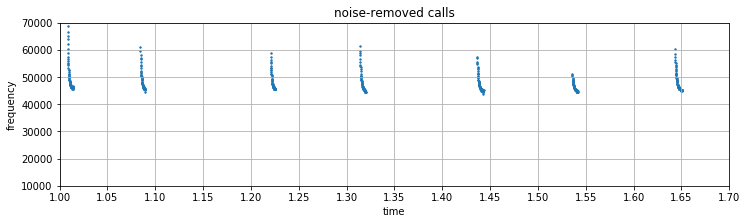

In [28]:
#visualization
plt.figure(figsize=(12,3))
plt.scatter(tf[0], tf[1], s=2)
plt.xticks(np.arange(1, 1.8, 0.05))
plt.xlim(1, 1.7)
plt.ylim(10000, 70000)
plt.title("noise-removed calls")
plt.xlabel("time")
plt.ylabel("frequency")
plt.grid()

In [10]:
# length of pulses in a given zc file
num = len(pulses)
num 

22

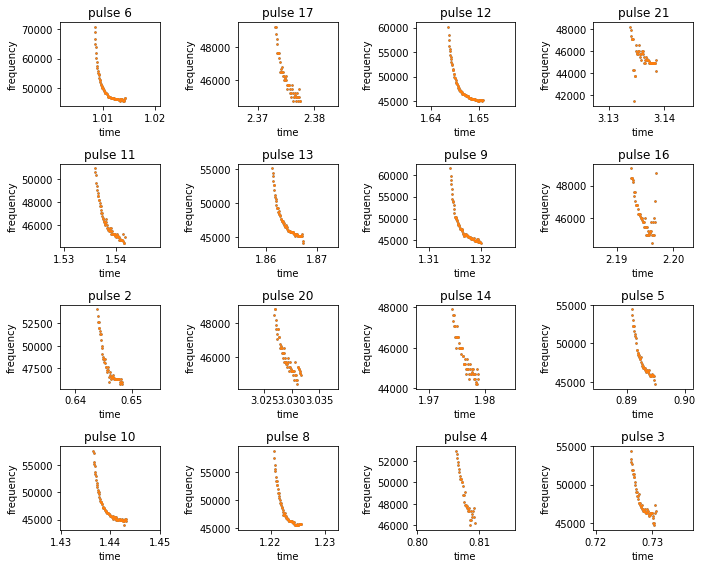

In [11]:
display_pulses(pulses, size=16,nrows=4, figsize=(10,8))

# Search abnormal labeled data files in a folder

Call get_labeled_file util method in anabat module.

In [12]:
# Example of find bat acoustic files contains social call (have "social" label in metadata)
datadir='D:\\dropbox_backup\\acoustic social auto id\\bat recordings\\transects\\2018\\cell-75\\20180715\\'
label='social'
get_labeled_file(datadir,label)

No handlers could be found for logger "util.bat"


['S7152113.44#', 'S7152121.42#']

# Descriptive Analysis

15kHz-120kHz

5% of social calls.

In [13]:
data2015 = pd.read_csv('../data/2015_night.txt', sep="\t")
data2016 = pd.read_csv('../data/2016_night.txt', sep="\t")
data2017 = pd.read_csv('../data/2017_night.txt', sep="\t")
data2018 = pd.read_csv('../data/2018_night.txt', sep="\t")

In [14]:
data2018[15:30]

,Folder1,Folder2,Night,Label,Number
15,cell-100,20180725,2018/07/25,NOID,7
16,cell-100,20180725,2018/07/25,PESU,2
17,cell-100,20180725,2018/07/25,foraging,1
18,cell-100,20180726,2018/07/26,EPFU,18
19,cell-100,20180726,2018/07/26,LABO,13
20,cell-100,20180726,2018/07/26,LACI,3
21,cell-100,20180726,2018/07/26,LANO,6
22,cell-100,20180726,2018/07/26,MYSPP,3
23,cell-100,20180726,2018/07/26,NOID,23
24,cell-100,20180726,2018/07/26,NYHU,2


In [15]:
# data2015['Label'].unique

In [16]:
def count_recordings(df, label=None):
    """
     Given a data table and the label, return the counts in this table with certain label
     label=None --- find the total recording counts
     label=social --- find the recording count for files containing 'social' label
     label=foraging --- find the recording count for files containing 'foraging' label
     label=Feeding --- find the recording count for files containing 'Feeding' label
     
     """
    if label=='social':
        count=df[df['Label'].str.contains('social')==True]['Number'].sum()
    elif label=='foraging':
        count=df[df['Label'].str.contains('foraging')==True]['Number'].sum()
    elif label=='Feeding':
        count=df[df['Label'].str.contains('Feeding')==True]['Number'].sum()
    else:
        count=df[df['Label'].str.contains('social|foraging|Feeding')==False]['Number'].sum()
    
    return count
    

In [17]:
# how many bat recordings in 2015
count_recordings(data2015)

2527

In [18]:
# how many social labeled recording in 2015
count_recordings(data2015,'social')

13

In [19]:
subt2015=count_recordings(data2015)
subt2016=count_recordings(data2016)
subt2017=count_recordings(data2017)
subt2018=count_recordings(data2018)
#total sample size
totalss=subt2015+subt2016+subt2017+subt2018
totalss

10626

In [20]:
totalsocial=count_recordings(data2015,'social')+count_recordings(data2016,'social')+count_recordings(data2017,'social')+count_recordings(data2018,'social')
totalsocial

29

In [21]:
totalforaging=count_recordings(data2015,'foraging')+count_recordings(data2016,'foraging')+count_recordings(data2017,'foraging')+count_recordings(data2018,'foraging')
totalforaging

155

In [22]:
totalfeeding=count_recordings(data2015,'Feeding')+count_recordings(data2016,'Feeding')+count_recordings(data2017,'Feeding')+count_recordings(data2018,'Feeding')
totalfeeding

12

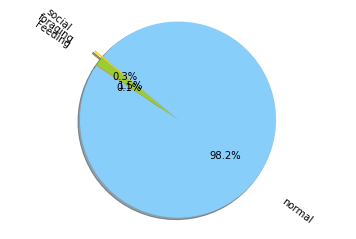

In [28]:
# Data to plot
labels = 'social', 'foraging', 'Feeding', 'normal'
sizes = [totalsocial, totalforaging, totalfeeding, totalss-totalsocial-totalforaging-totalfeeding]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140,rotatelabels=True,labeldistance=1.3)
 
plt.axis('equal')
plt.show()
# social:0.3%  foraging:1.5%  Feeding:0.1%  normal:98.2% 

# Bulk import and processing

In [2]:
datadir='D:\\dropbox_backup\\acoustic social auto id\\bat recordings\\transects\\2018\\cell-75\\20180715\\'

result=bulk_processing(datadir)

No handlers could be found for logger "util.bat"


In [3]:
len(result[0])#124 2091


1096

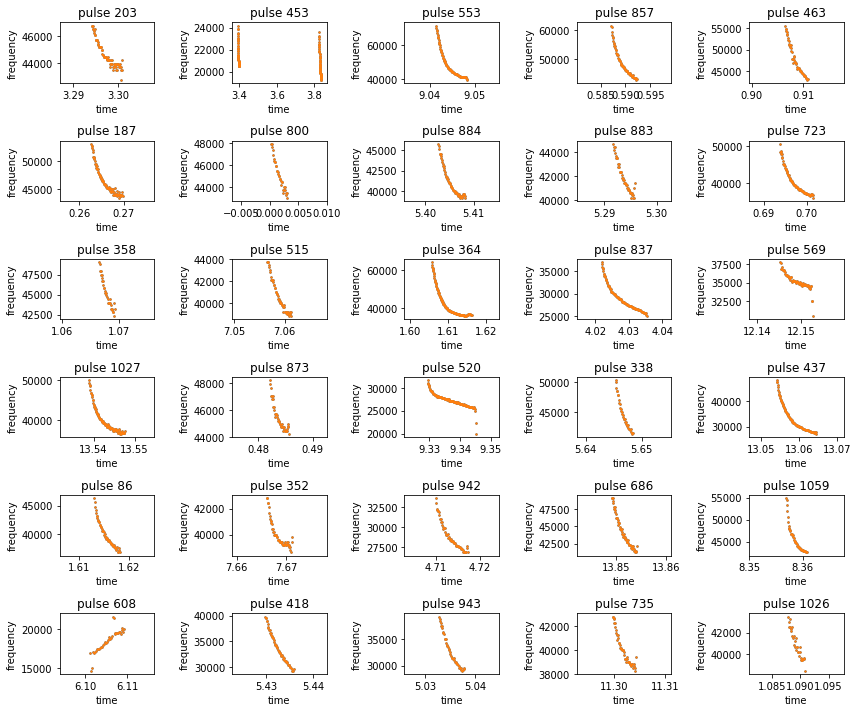

In [6]:
display_pulses(result[0],30,6,figsize=(12,10),rand_flag=True)

# Data Analysis

In [3]:
vpulses=result[0]
b,c=get_dy_dy2(vpulses)
bf=get_features(b)
cf=get_features(c)
bf.iloc[8:11,]
cf.iloc[8:11,]
# ff=pd.concat([bf, cf.iloc[:,0:2]], axis=1)
# ff.iloc[8:11,]

,mean,std,min,25%,50%,75%,max
0,7.583767,294.208433,-434.934752,-213.880484,-5.157165e+01,294.182257,646.429822
0,1.158445,703.424871,-2586.668553,-99.537152,3.637979e-12,99.522600,5308.924198
0,3.057031,526.678718,-2634.067582,-212.142198,0.000000e+00,187.613119,3066.436925


Text(0,0.5,'counts')

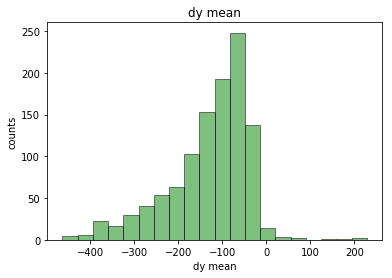

In [4]:
# dy_mean most of them smaller than 0(normal calls), handful larger than 0(abnormal calls)
# bf.iloc[:,0].hist(density=True, bins=20,facecolor='green', alpha=0.5, ec='black')
plt.hist(bf.iloc[:,0], bins=20,  facecolor='green', alpha=0.5,ec='black')
plt.title('dy mean')
plt.xlabel('dy mean')
plt.ylabel('counts')

C:\ProgramData\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Freq 1st Differencing(dy) Mean')

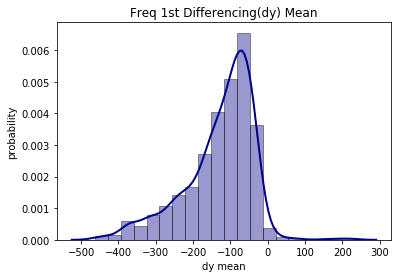

In [23]:
#dy mean
fig=sns.distplot(bf.iloc[:,0], hist=True, kde=True,
             bins=20, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
fig.set(xlabel='dy mean', ylabel='probability')
fig.set_title('Freq 1st Differencing(dy) Mean')

Text(0,0.5,'counts')

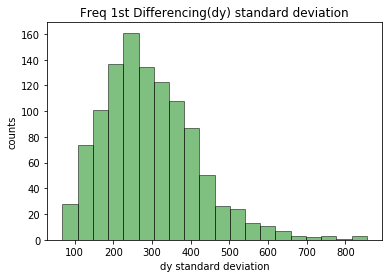

In [24]:
#dy sd
# bf.iloc[:,1].hist(density=True, bins=20, facecolor='green',alpha=0.5,ec='black',ax=get.title())
plt.hist(bf.iloc[:,1], bins=20,  facecolor='green', alpha=0.5,ec='black')
plt.title('Freq 1st Differencing(dy) standard deviation')
plt.xlabel('dy standard deviation')
plt.ylabel('counts')

C:\ProgramData\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Freq 1st Differencing(dy) standard deviation')

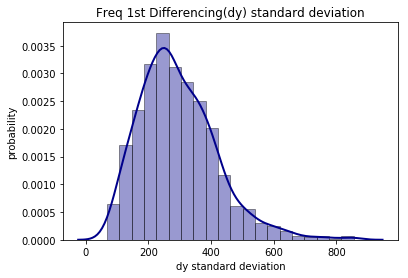

In [28]:
#dy sd
fig=sns.distplot(bf.iloc[:,1], hist=True, kde=True,
             bins=20, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
fig.set(xlabel='dy standard deviation', ylabel='probability')
fig.set_title('Freq 1st Differencing(dy) standard deviation')

Text(0,0.5,'counts')

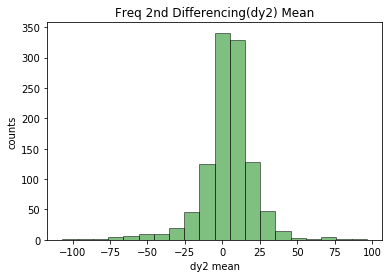

In [30]:
#dy2 mean
# cf.iloc[:,0].hist(density=True, bins=20, ec='black')
plt.hist(cf.iloc[:,0], bins=20,  facecolor='green', alpha=0.5,ec='black')
plt.title('Freq 2nd Differencing(dy2) Mean')
plt.xlabel('dy2 mean')
plt.ylabel('counts')

C:\ProgramData\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Freq 2nd Differencing(dy2) Mean')

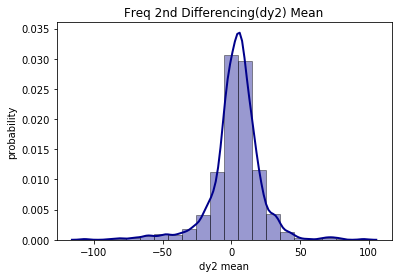

In [31]:
#dy2 mean
fig=sns.distplot(cf.iloc[:,0], hist=True, kde=True,
             bins=20, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
fig.set(xlabel='dy2 mean', ylabel='probability')
fig.set_title('Freq 2nd Differencing(dy2) Mean')

In [32]:
# result[0][1:100]

In [33]:
import pandas as pd
tf=pd.DataFrame(result[0])
tf[1].min()

[0.00027899999999999995, 55944.055944055945]